In [1]:
# Set working directory (optional during development)
import os
os.chdir('/Users/sudishmakarki/My_project2')  # only if needed
print(" Working directory:", os.getcwd())

# Standard Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from prophet.diagnostics import cross_validation, performance_metrics




# Custom Functions
from models.data_interpolation import (
    load_data,
    preprocess_data,
    split_train_test,
    generate_time_series_splits
)

from models.model_prophet import (
    prepare_prophet_data,
    train_baseline_prophet,
    forecast_with_model,
    calculate_peak_hours,
    evaluate_metrics,
    cross_validate_baseline
)

from models.model_prophet import (
    tune_prophet_model,
    forecast_with_model_r1,
    select_peak_hours,
    evaluate_tuned_model_metrics,
    cross_validate_tuned_r1
)

 Working directory: /Users/sudishmakarki/My_project2


In [2]:
# Load and preprocess
df = load_data('data/RestaurantData.csv')
df_clean = preprocess_data(df)

                     Year  Month  Season  DayOfWeek WeekDay  Hour  \
Timestamp                                                           
2018-01-01 00:00:00  2018      1  Winter          1  Monday     0   
2018-01-01 01:00:00  2018      1  Winter          1  Monday     1   
2018-01-01 02:00:00  2018      1  Winter          1  Monday     2   
2018-01-01 03:00:00  2018      1  Winter          1  Monday     3   
2018-01-01 04:00:00  2018      1  Winter          1  Monday     4   

                            Holiday Weather SpecialEvent  CustomerCount  \
Timestamp                                                                 
2018-01-01 00:00:00  New Year's Day   Rainy          NaN              6   
2018-01-01 01:00:00  New Year's Day   Windy          NaN             11   
2018-01-01 02:00:00  New Year's Day   Snowy          NaN              9   
2018-01-01 03:00:00  New Year's Day   Rainy          NaN             10   
2018-01-01 04:00:00  New Year's Day  Cloudy          NaN          

In [3]:
# Split into train and test
restaurant_train, restaurant_test = split_train_test(df_clean, split_date='2022-01-01')
# Format for Prophet
restaurant_train_prophet, restaurant_test_prophet = prepare_prophet_data(restaurant_train, restaurant_test)
# Train the baseline Prophet model
m = train_baseline_prophet(restaurant_train_prophet)

In [4]:
# -- Test Set Forecasting --
# Predict on the test set and display the first few rows
test_forecast_df = forecast_with_model(m, restaurant_test_prophet)
print("Forecast on Test Set (first 5 rows):")
test_forecast_df.head()


Forecast on Test Set (first 5 rows):


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,Hour
0,2022-01-01 00:00:00,20.446485,-0.462059,18.867524,20.446485,20.446485,-11.624321,-11.624321,-11.624321,-13.541767,-13.541767,-13.541767,3.103691,3.103691,3.103691,-1.186246,-1.186246,-1.186246,0.0,0.0,0.0,8.822164,0
1,2022-01-01 01:00:00,20.446561,1.236642,20.031072,20.446561,20.446561,-9.794884,-9.794884,-9.794884,-11.618675,-11.618675,-11.618675,3.010379,3.010379,3.010379,-1.186589,-1.186589,-1.186589,0.0,0.0,0.0,10.651677,1
2,2022-01-01 02:00:00,20.446637,1.983290,21.749536,20.446637,20.446637,-8.705095,-8.705095,-8.705095,-10.416109,-10.416109,-10.416109,2.897975,2.897975,2.897975,-1.186961,-1.186961,-1.186961,0.0,0.0,0.0,11.741542,2
3,2022-01-01 03:00:00,20.446713,1.066808,20.491768,20.446713,20.446713,-10.132657,-10.132657,-10.132657,-11.712865,-11.712865,-11.712865,2.767571,2.767571,2.767571,-1.187363,-1.187363,-1.187363,0.0,0.0,0.0,10.314056,3
4,2022-01-01 04:00:00,20.446789,-0.385343,18.360888,20.446789,20.446789,-11.764320,-11.764320,-11.764320,-13.196955,-13.196955,-13.196955,2.620430,2.620430,2.620430,-1.187795,-1.187795,-1.187795,0.0,0.0,0.0,8.682469,4


In [5]:
# Calculate average forecast per hour
hourly_avg = test_forecast_df.groupby('Hour')['yhat'].mean()
print("\nAverage Forecast by Hour:")
display(hourly_avg)


Average Forecast by Hour:


Hour
0      7.246245
1      9.169158
2     10.371492
3      9.074454
4      7.590038
5      8.459568
6     11.104544
7     12.760900
8     12.392444
9     12.769541
10    17.787457
11    27.462583
12    36.149942
13    36.782499
14    27.776974
15    15.894710
16    11.539598
17    20.027610
18    36.537792
19    49.516678
20    49.785918
21    37.493399
22    21.121063
23     9.987529
Name: yhat, dtype: float64

In [6]:
peak_hours_dynamic, hourly_avg, threshold = calculate_peak_hours(test_forecast_df)

print("\nThreshold for Peak Hours:", threshold)
print("\nDynamically Identified Peak Hours:", peak_hours_dynamic)

# Filter forecast and actuals for dynamically identified peak hours
forecast_peak_df = test_forecast_df[test_forecast_df['Hour'].isin(peak_hours_dynamic)]
actual_peak_df = restaurant_test_prophet[restaurant_test_prophet['Hour'].isin(peak_hours_dynamic)]


Threshold for Peak Hours: 29.87155088616458

Dynamically Identified Peak Hours: [12, 13, 18, 19, 20, 21]


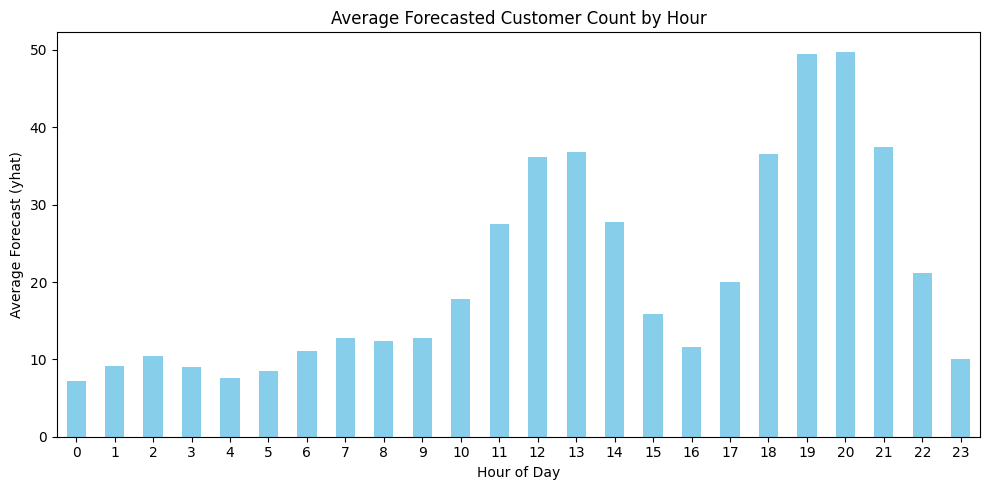

In [7]:
# ----- Average forecasted customer count by hour -----
plt.figure(figsize=(10, 5))
hourly_avg.plot(kind='bar', color='skyblue')
plt.title("Average Forecasted Customer Count by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Average Forecast (yhat)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

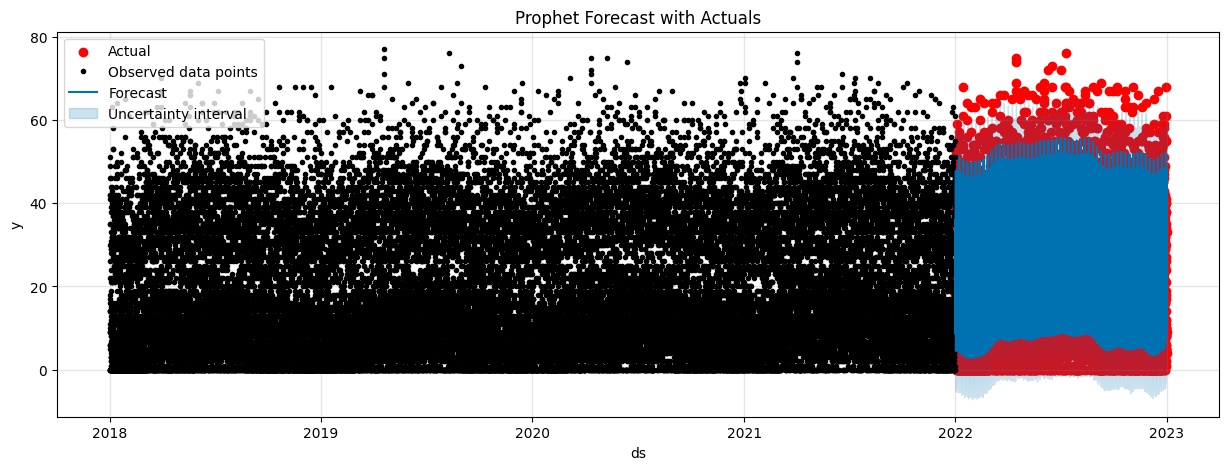

In [8]:
# ----- Compare Forecast to Actuals (All Hours) -----
# Plot the forecast with the actual test values
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(restaurant_test.index, restaurant_test['CustomerCount'], color='r', label='Actual')
fig = m.plot(test_forecast_df, ax=ax)
ax.set_title("Prophet Forecast with Actuals")
ax.legend()
plt.show()

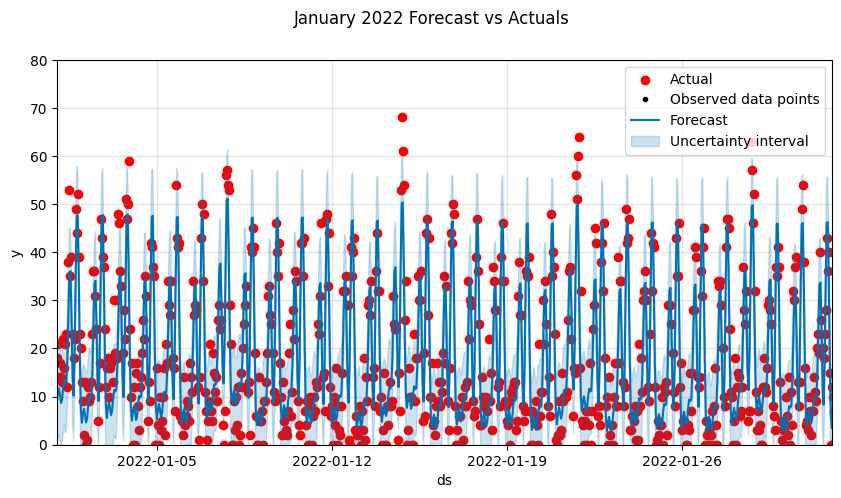

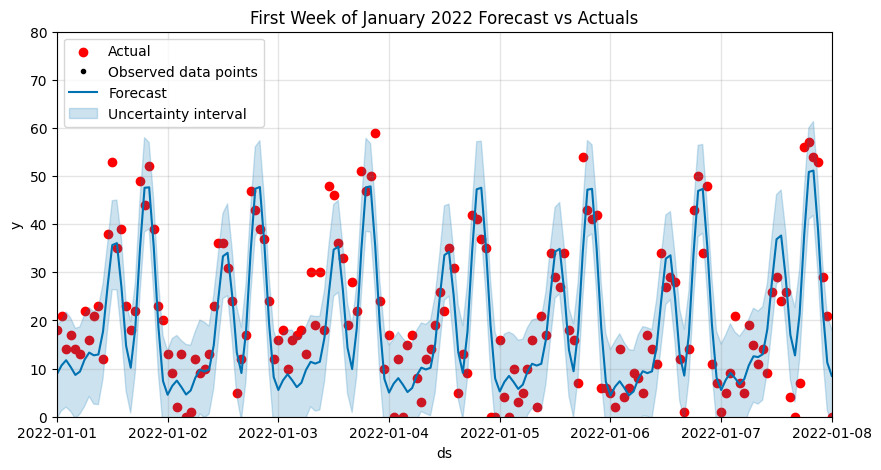

In [9]:
# ----- Zoom In: January 2022 (All Hours) -----
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(restaurant_test.index, restaurant_test['CustomerCount'], color='r', label='Actual')
fig = m.plot(test_forecast_df, ax=ax)
ax.set_xbound(lower=pd.to_datetime('2022-01-01'), upper=pd.to_datetime('2022-02-01'))
ax.set_ylim(0, 80)
plt.suptitle('January 2022 Forecast vs Actuals')
ax.legend()
plt.show()

# ----- Zoom In Further: First Week of January 2022 (All Hours) -----
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(restaurant_test.index, restaurant_test['CustomerCount'], color='r', label='Actual')
fig = m.plot(test_forecast_df, ax=ax)
lower_bound = pd.to_datetime('2022-01-01')
upper_bound = pd.to_datetime('2022-01-08')
ax.set_xbound(lower=lower_bound, upper=upper_bound)
ax.set_ylim(0, 80)
ax.set_title('First Week of January 2022 Forecast vs Actuals')
ax.legend()
plt.show()

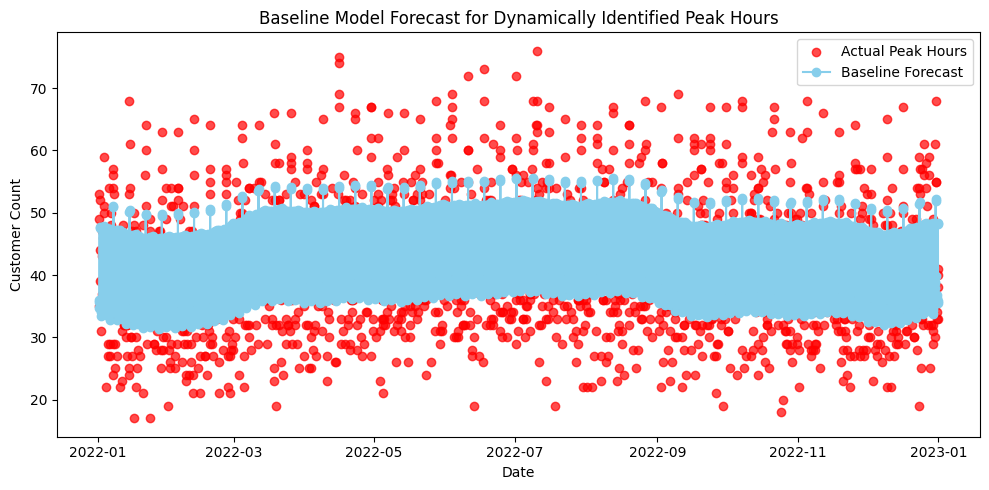

In [10]:
# ----- Compare Forecast vs. Actuals for Dynamically Identified Peak Hours -----
plt.figure(figsize=(10, 5))
plt.scatter(actual_peak_df['ds'], actual_peak_df['y'], 
            color='r', label='Actual Peak Hours', alpha=0.7)

plt.plot(forecast_peak_df['ds'], forecast_peak_df['yhat'], 
         marker='o', linestyle='-', color='skyblue', label='Baseline Forecast')

plt.xlabel('Date')
plt.ylabel('Customer Count')
plt.title('Baseline Model Forecast for Dynamically Identified Peak Hours')
plt.legend()
plt.tight_layout()
plt.show()

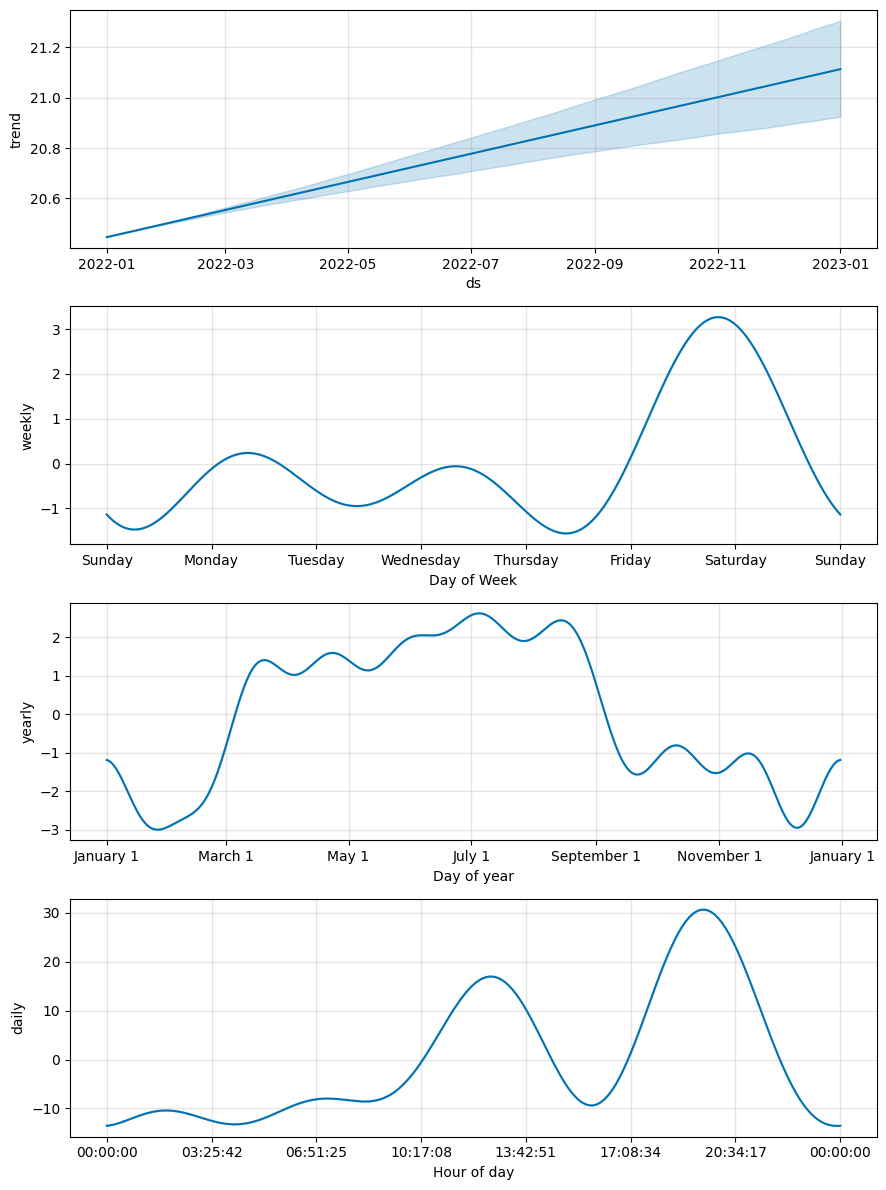

In [11]:
# ----- Plot Prophet Components for the Test Forecast -----
fig = m.plot_components(test_forecast_df)
plt.show()

Future Forecast:


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-01 00:00:00,16.782304,-7.986557,12.060899,16.782304,16.782304,-14.846169,-14.846169,-14.846169,-13.541767,-13.541767,-13.541767,-0.118157,-0.118157,-0.118157,-1.186246,-1.186246,-1.186246,0.0,0.0,0.0,1.936135
1,2018-01-01 01:00:00,16.782411,-5.679396,13.720840,16.782411,16.782411,-12.845962,-12.845962,-12.845962,-11.618675,-11.618675,-11.618675,-0.040698,-0.040698,-0.040698,-1.186589,-1.186589,-1.186589,0.0,0.0,0.0,3.936449
2,2018-01-01 02:00:00,16.782518,-4.169243,14.361460,16.782518,16.782518,-11.574556,-11.574556,-11.574556,-10.416109,-10.416109,-10.416109,0.028515,0.028515,0.028515,-1.186961,-1.186961,-1.186961,0.0,0.0,0.0,5.207962
3,2018-01-01 03:00:00,16.782625,-6.055843,14.198462,16.782625,16.782625,-12.811536,-12.811536,-12.811536,-11.712865,-11.712865,-11.712865,0.088693,0.088693,0.088693,-1.187363,-1.187363,-1.187363,0.0,0.0,0.0,3.971089
4,2018-01-01 04:00:00,16.782732,-7.618343,12.429896,16.782732,16.782732,-14.245559,-14.245559,-14.245559,-13.196955,-13.196955,-13.196955,0.139190,0.139190,0.139190,-1.187795,-1.187795,-1.187795,0.0,0.0,0.0,2.537172


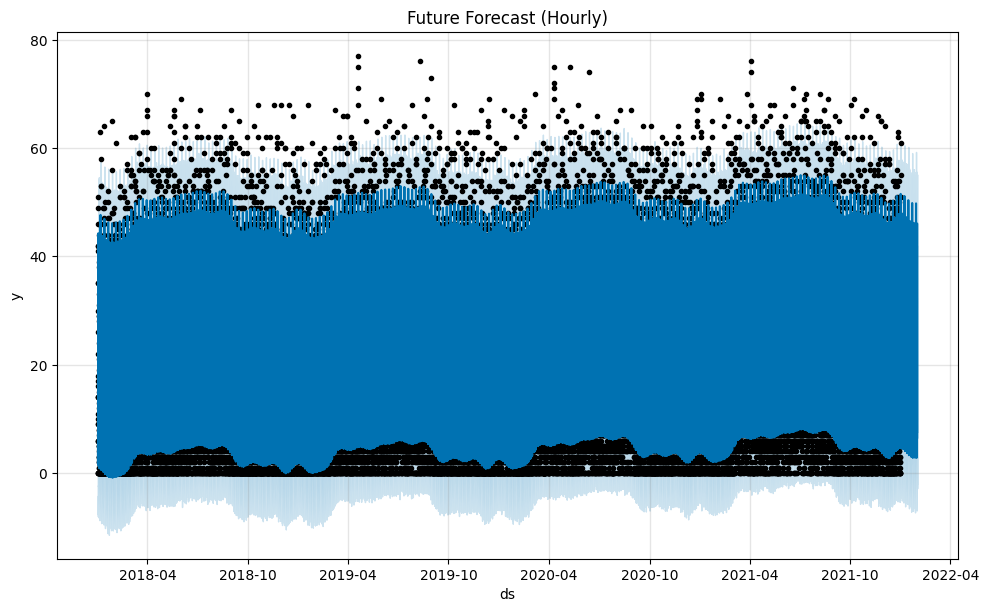


Future Average Forecast by Hour:
Hour
0      5.030926
1      6.954072
2      8.156692
3      6.859991
4      5.375956
5      6.245909
6      8.891347
7     10.548197
8     10.180264
9     10.557907
10    15.576386
11    25.252087
12    33.940030
13    34.573171
14    25.568225
15    13.686532
16     9.331976
17    17.820524
18    34.331219
19    47.310589
20    47.580281
21    35.288178
22    18.916220
23     7.783022
Name: yhat, dtype: float64

Threshold for Peak Hours: 28.548168889830286

Dynamically Selected Peak Hours: [12, 13, 18, 19, 20, 21]


In [12]:
# -- Future Forecasting (baseline) --
# Generate future data for the next 30 days at hourly frequency
future = m.make_future_dataframe(periods=30*24, freq='h')
forecast_future = m.predict(future)

print("Future Forecast:")
display(forecast_future.head())

# Plot the future forecast (historical data in black, forecast in blue)
m.plot(forecast_future)
plt.title("Future Forecast (Hourly)")
plt.show()

# Calculate the average forecast (yhat) per hour from the future forecast
forecast_future['Hour'] = forecast_future['ds'].dt.hour
future_hourly_avg = forecast_future.groupby('Hour')['yhat'].mean()
print("\nFuture Average Forecast by Hour:")
print(future_hourly_avg)

# Define a threshold based on the maximum forecast value (e.g., 60% of max)
threshold = 0.6 * future_hourly_avg.max()
print("\nThreshold for Peak Hours:", threshold)

# Dynamically select all hours where the forecast meets or exceeds the threshold
future_peak_hours = sorted([hour for hour, demand in future_hourly_avg.items() if demand >= threshold])
print("\nDynamically Selected Peak Hours:", future_peak_hours)

In [13]:
# ----- Evaluate Error Metrics for All Test Data -----
mae_all = mean_absolute_error(
    y_true=restaurant_test['CustomerCount'],
    y_pred=test_forecast_df['yhat']
)
rmse_all = np.sqrt(mean_squared_error(
    y_true=restaurant_test['CustomerCount'],
    y_pred=test_forecast_df['yhat']
))
mape_all = mean_absolute_percentage_error(
    y_true=restaurant_test['CustomerCount'],
    y_pred=test_forecast_df['yhat']
)

print("Overall Test Data Metrics:")
print("MAE:", mae_all)
print("RMSE:", rmse_all)
print("MAPE:", mape_all)

Overall Test Data Metrics:
MAE: 6.178832523928045
RMSE: 7.792611337402785
MAPE: 1750259904361487.0


In [14]:
# ----- Evaluate Error Metrics for Peak Hours -----
# Align the forecasts and actual values by their datetime 'ds' for peak hours
actual_peak = actual_peak_df.set_index('ds')['y']
predicted_peak = forecast_peak_df.set_index('ds')['yhat']

mae_peak = mean_absolute_error(actual_peak, predicted_peak)
rmse_peak = np.sqrt(mean_squared_error(actual_peak, predicted_peak))
mape_peak = mean_absolute_percentage_error(actual_peak, predicted_peak)

print("\nPeak Hours Metrics:")
print("Baseline Peak Hours MAE:", mae_peak)
print("Baseline Peak Hours RMSE:", rmse_peak)
print("Baseline Peak Hours MAPE:", mape_peak)


Peak Hours Metrics:
Baseline Peak Hours MAE: 7.438054978068848
Baseline Peak Hours RMSE: 9.273396642585928
Baseline Peak Hours MAPE: 0.1853811961525984


In [24]:
# Use your baseline model (m) for cross-validation.
df_cv_baseline = cross_validation(m, initial='730 days', period='180 days', horizon='365 days')
df_p_baseline = performance_metrics(df_cv_baseline)

print("Cross-Validation Performance Metrics for Baseline Model:")
df_p_baseline.head()

  0%|          | 0/3 [00:00<?, ?it/s]

Cross-Validation Performance Metrics for Baseline Model:


,horizon,mse,rmse,mae,mdape,smape,coverage
0,36 days 12:00:00,51.469030,7.174192,5.640334,0.316656,0.537412,0.816971
1,36 days 13:00:00,51.363676,7.166846,5.633327,0.316138,0.536468,0.817352
2,36 days 14:00:00,51.326250,7.164234,5.630596,0.315422,0.535417,0.817352
3,36 days 15:00:00,51.385046,7.168336,5.631366,0.314798,0.534419,0.816971
4,36 days 16:00:00,51.372589,7.167467,5.629546,0.314319,0.533671,0.816971


In [ ]:
##Cross-Validation Summary for baseline
print("Cross-Validation Performance Metrics (Average) for Baseline Model (Overall):")
available_metrics = ['rmse', 'mae', 'mape', 'smape']

for metric in available_metrics:
    if metric in df_p_baseline.columns:
        print(f"{metric.upper()}: {df_p_baseline[metric].mean():.3f}")

Cross-Validation Performance Metrics (Average) for Baseline Model (Overall):
RMSE: 7.571
MAE: 6.012
SMAPE: 0.488


In [ ]:
#  Peak Hours CV Metrics for baseline
df_cv_baseline['Hour'] = df_cv_baseline['ds'].dt.hour
df_cv_baseline_peak = df_cv_baseline[df_cv_baseline['Hour'].isin(peak_hours_dynamic)]

rmse_peak = np.sqrt(mean_squared_error(df_cv_baseline_peak['y'], df_cv_baseline_peak['yhat']))
mae_peak = mean_absolute_error(df_cv_baseline_peak['y'], df_cv_baseline_peak['yhat'])
mape_peak = mean_absolute_percentage_error(df_cv_baseline_peak['y'], df_cv_baseline_peak['yhat'])

# SMAPE custom calculation
smape_peak = 100 * np.mean(
    2 * np.abs(df_cv_baseline_peak['yhat'] - df_cv_baseline_peak['y']) /
    (np.abs(df_cv_baseline_peak['yhat']) + np.abs(df_cv_baseline_peak['y']))
)

print("\nCross-Validation Performance Metrics (Average) for Baseline Model (Peak Hours Only):")
print(f"RMSE: {rmse_peak:.3f}")
print(f"MAE: {mae_peak:.3f}")
print(f"MAPE: {mape_peak:.3f}")
print(f"SMAPE: {smape_peak:.3f}")


Cross-Validation Performance Metrics (Average) for Baseline Model (Peak Hours Only):
RMSE: 9.187
MAE: 7.304
MAPE: 0.192
SMAPE: 18.427


In [ ]:
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5, 1.0],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_range': [0.8, 0.9, 1.0]
}

m_best_r1, best_params, tuning_results = tune_prophet_model(
    train_df=restaurant_train_prophet,
    test_df=restaurant_test_prophet,
    param_grid=param_grid
)

Hyperparameter Tuning (Composite = RMSE + MAE):
Params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8} --> RMSE: 7.7878, MAE: 6.1805, Composite: 13.9682
Params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9} --> RMSE: 7.7878, MAE: 6.1805, Composite: 13.9682
Params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 1.0} --> RMSE: 7.7878, MAE: 6.1805, Composite: 13.9682
Params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8} --> RMSE: 7.7873, MAE: 6.1853, Composite: 13.9727
Params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9} --> RMSE: 7.7873, MAE: 6.1853, Composite: 13.9727
Params: {'changepoin

In [ ]:
# -- Test Set Forecasting with the Tuned Model --
restaurant_test_fcst_best_r1 = forecast_with_model_r1(m_best_r1, restaurant_test_prophet)
restaurant_test_fcst_best_r1.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,Hour
0,2022-01-01 00:00:00,20.493384,-0.825241,18.573527,20.493384,20.493384,-11.558638,-11.558638,-11.558638,-13.469402,-13.469402,-13.469402,3.087093,3.087093,3.087093,-1.176329,-1.176329,-1.176329,0.0,0.0,0.0,8.934746,0
1,2022-01-01 01:00:00,20.493493,1.359797,20.534261,20.493493,20.493493,-9.738844,-9.738844,-9.738844,-11.556553,-11.556553,-11.556553,2.994288,2.994288,2.994288,-1.176579,-1.176579,-1.176579,0.0,0.0,0.0,10.754649,1
2,2022-01-01 02:00:00,20.493602,2.581774,20.945516,20.493602,20.493602,-8.654748,-8.654748,-8.654748,-10.360383,-10.360383,-10.360383,2.882492,2.882492,2.882492,-1.176858,-1.176858,-1.176858,0.0,0.0,0.0,11.838854,2
3,2022-01-01 03:00:00,20.493712,0.475170,19.670765,20.493712,20.493712,-10.074568,-10.074568,-10.074568,-11.650193,-11.650193,-11.650193,2.752792,2.752792,2.752792,-1.177166,-1.177166,-1.177166,0.0,0.0,0.0,10.419144,3
4,2022-01-01 04:00:00,20.493821,-1.122577,19.016514,20.493821,20.493821,-11.697421,-11.697421,-11.697421,-13.126359,-13.126359,-13.126359,2.606442,2.606442,2.606442,-1.177504,-1.177504,-1.177504,0.0,0.0,0.0,8.796400,4


In [ ]:
# Continue with your analysis using the tuned forecasts:
restaurant_test_fcst_best_r1['Hour'] = restaurant_test_fcst_best_r1['ds'].dt.hour
hourly_avg_best_r1 = restaurant_test_fcst_best_r1.groupby('Hour')['yhat'].mean()
print("\nAverage Forecast by Hour (Tuned Model):")
print(hourly_avg_best_r1)



Average Forecast by Hour (Tuned Model):
Hour
0      7.510793
1      9.423497
2     10.619471
3      9.329414
4      7.852957
5      8.717848
6     11.348691
7     12.996204
8     12.629744
9     13.004869
10    17.996019
11    27.619487
12    36.260457
13    36.889657
14    27.932274
15    16.113526
16    11.781710
17    20.224391
18    36.646376
19    49.555937
20    49.823770
21    37.596973
22    21.312166
23    10.238175
Name: yhat, dtype: float64


In [ ]:
# --- Select Peak Hours using the forecasted test set and actual test data ---

(
    peak_hours_dynamic_best_r1,           
    threshold_best_r1,                    
    tuned_peak_fcst_dynamic_best_r1,      
    restaurant_test_prophet_peak_dynamic_best_r1,  
    hourly_avg_best_r1                   
) = select_peak_hours(
    restaurant_test_fcst_best_r1,         
    restaurant_test_prophet,              
    threshold_ratio=0.6                  
)

# View results
print("Threshold for Peak Hours:", threshold_best_r1)
print("Dynamically Identified Peak Hours:", peak_hours_dynamic_best_r1)

Threshold for Peak Hours: 29.89426222181091
Dynamically Identified Peak Hours: [12, 13, 18, 19, 20, 21]


In [ ]:
# Evaluate error metrics for the tuned model (overall)
mae_all_best_r1 = mean_absolute_error(
    y_true=restaurant_test['CustomerCount'],
    y_pred=restaurant_test_fcst_best_r1['yhat']
)
rmse_all_best_r1 = np.sqrt(mean_squared_error(
    y_true=restaurant_test['CustomerCount'],
    y_pred=restaurant_test_fcst_best_r1['yhat']
))
mape_all_best_r1 = mean_absolute_percentage_error(
    y_true=restaurant_test['CustomerCount'],
    y_pred=restaurant_test_fcst_best_r1['yhat']
)
print("\nTuned Model Overall Test Data Metrics:")
print("MAE:", mae_all_best_r1)
print("RMSE:", rmse_all_best_r1)
print("MAPE:", mape_all_best_r1)



Tuned Model Overall Test Data Metrics:
MAE: 6.1804818847201055
RMSE: 7.787756838129002
MAPE: 1799928417792683.2


In [ ]:
# Evaluate error metrics for the tuned model (overall and for peak hours)
actual_peak_best_r1 = restaurant_test_prophet_peak_dynamic_best_r1.set_index('ds')['y']
predicted_peak_best_r1 = tuned_peak_fcst_dynamic_best_r1.set_index('ds')['yhat']
mae_peak_best_r1 = mean_absolute_error(actual_peak_best_r1, predicted_peak_best_r1)
rmse_peak_best_r1 = np.sqrt(mean_squared_error(actual_peak_best_r1, predicted_peak_best_r1))
mape_peak_best_r1 = mean_absolute_percentage_error(actual_peak_best_r1, predicted_peak_best_r1)
print("\nTuned Model Peak Hours Metrics:")
print("MAE:", mae_peak_best_r1)
print("RMSE:", rmse_peak_best_r1)
print("MAPE:", mape_peak_best_r1)


Tuned Model Peak Hours Metrics:
MAE: 7.4295155584022385
RMSE: 9.25714616325585
MAPE: 0.18551151193478085


In [ ]:
#----Cross_validation----
df_cv_r1 = cross_validation(m_best_r1, initial='730 days', period='180 days', horizon='365 days')
df_p_r1 = performance_metrics(df_cv_r1)

print("\nCross-Validation Performance Metrics (First 5 rows) for Tuned Model (Refinement 1):")
df_p_r1.head()

  0%|          | 0/3 [00:00<?, ?it/s]


Cross-Validation Performance Metrics (First 5 rows) for Tuned Model (Refinement 1):


,horizon,mse,rmse,mae,mdape,smape,coverage
0,36 days 12:00:00,51.537247,7.178945,5.635812,0.314221,0.537066,0.818493
1,36 days 13:00:00,51.431891,7.171603,5.628728,0.314035,0.536129,0.818874
2,36 days 14:00:00,51.393289,7.168911,5.625961,0.313678,0.535081,0.818874
3,36 days 15:00:00,51.452559,7.173044,5.626841,0.313479,0.534086,0.818493
4,36 days 16:00:00,51.440630,7.172212,5.625028,0.313468,0.533340,0.818493


In [ ]:
#Cross-Validation Summary
available_metrics = ['rmse', 'mae', 'mape', 'smape']

for metric in available_metrics:
    if metric in df_p_r1.columns:
        print(f"{metric.upper()}: {df_p_r1[metric].mean():.3f}")

RMSE: 7.572
MAE: 6.008
SMAPE: 0.487


In [ ]:
# Peak Hours CV Metrics
df_cv_r1['hour'] = df_cv_r1['ds'].dt.hour
df_cv_r1_peak = df_cv_r1[df_cv_r1['hour'].isin(peak_hours_dynamic_best_r1)]
df_p_r1_peak = performance_metrics(df_cv_r1_peak)

# Display average metrics
print("\nCross-Validation Performance Metrics (Average) for Peak Hours Only:")
for metric in ['rmse', 'mae', 'mape', 'smape']:
    if metric in df_p_r1_peak.columns:
        print(f"{metric.upper()}: {df_p_r1_peak[metric].mean():.3f}")


Cross-Validation Performance Metrics (Average) for Peak Hours Only:
RMSE: 9.185
MAE: 7.297
MAPE: 0.191
SMAPE: 0.184
